In [1]:
!conda install -y dask numpy scipy matplotlib toolz

Fetching package metadata: ........
Solving package specifications: .........

# All requested packages already installed.
# packages in environment at /home/lomereiter/miniconda2/envs/ims:
#
dask                      0.8.2                    py27_0  
matplotlib                1.5.1               np111py27_0  
numpy                     1.11.0                   py27_0  
scipy                     0.17.0              np111py27_2  
toolz                     0.7.4                    py27_0  


In [2]:
!pip install cpyImagingMSpec

In [3]:
# https://github.com/kimjingu/nonnegfac-python/blob/master/nonnegfac/nnls.py
#
# Copyright (c) 2014, Nokia Corporation
# All rights reserved.
# 
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#     * Redistributions in binary form must reproduce the above copyright
#       notice, this list of conditions and the following disclaimer in the
#       documentation and/or other materials provided with the distribution.
#     * Neither the name of the Nokia Corporation nor the
#       names of its contributors may be used to endorse or promote products
#       derived from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
# ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL NOKIA CORPORATION BE LIABLE FOR ANY
# DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
# ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
# SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

import numpy as np
import scipy.optimize as opt
import scipy.sparse as sps
import numpy.linalg as nla
import scipy.linalg as sla
import time

def nnlsm_blockpivot(A, B, is_input_prod=False, init=None):
    """ Nonnegativity-constrained least squares with block principal pivoting method and column grouping
    Solves min ||AX-B||_2^2 s.t. X >= 0 element-wise.
    J. Kim and H. Park, Fast nonnegative matrix factorization: An active-set-like method and comparisons,
    SIAM Journal on Scientific Computing, 
    vol. 33, no. 6, pp. 3261-3281, 2011.
    Parameters
    ----------
    A : numpy.array, shape (m,n)
    B : numpy.array or scipy.sparse matrix, shape (m,k)
    Optional Parameters
    -------------------
    is_input_prod : True/False. -  If True, the A and B arguments are interpreted as
            AtA and AtB, respectively. Default is False.
    init: numpy.array, shape (n,k). - If provided, init is used as an initial value for the algorithm.
            Default is None.
    Returns
    -------
    X, (success, Y, num_cholesky, num_eq, num_backup)
    X : numpy.array, shape (n,k) - solution
    success : True/False - True if the solution is found. False if the algorithm did not terminate
            due to numerical errors.
    Y : numpy.array, shape (n,k) - Y = A.T * A * X - A.T * B
    num_cholesky : int - the number of Cholesky factorizations needed
    num_eq : int - the number of linear systems of equations needed to be solved
    num_backup: int - the number of appearances of the back-up rule. See SISC paper for details.
    """
    if is_input_prod:
        AtA = A
        AtB = B
    else:
        AtA = A.T.dot(A)
        if sps.issparse(B):
            AtB = B.T.dot(A)
            AtB = AtB.T
        else:
            AtB = A.T.dot(B)

    (n, k) = AtB.shape
    MAX_ITER = n * 5

    if init != None:
        PassSet = init > 0
        X, num_cholesky, num_eq = normal_eq_comb(AtA, AtB, PassSet)
        Y = AtA.dot(X) - AtB
    else:
        X = np.zeros([n, k])
        Y = -AtB
        PassSet = np.zeros([n, k], dtype=bool)
        num_cholesky = 0
        num_eq = 0

    p_bar = 3
    p_vec = np.zeros([k])
    p_vec[:] = p_bar
    ninf_vec = np.zeros([k])
    ninf_vec[:] = n + 1
    not_opt_set = np.logical_and(Y < 0, ~PassSet)
    infea_set = np.logical_and(X < 0, PassSet)

    not_good = np.sum(not_opt_set, axis=0) + np.sum(infea_set, axis=0)
    not_opt_colset = not_good > 0
    not_opt_cols = not_opt_colset.nonzero()[0]

    big_iter = 0
    num_backup = 0
    success = True
    while not_opt_cols.size > 0:
        big_iter += 1
        if MAX_ITER > 0 and big_iter > MAX_ITER:
            success = False
            break

        cols_set1 = np.logical_and(not_opt_colset, not_good < ninf_vec)
        temp1 = np.logical_and(not_opt_colset, not_good >= ninf_vec)
        temp2 = p_vec >= 1
        cols_set2 = np.logical_and(temp1, temp2)
        cols_set3 = np.logical_and(temp1, ~temp2)

        cols1 = cols_set1.nonzero()[0]
        cols2 = cols_set2.nonzero()[0]
        cols3 = cols_set3.nonzero()[0]

        if cols1.size > 0:
            p_vec[cols1] = p_bar
            ninf_vec[cols1] = not_good[cols1]
            true_set = np.logical_and(not_opt_set, np.tile(cols_set1, (n, 1)))
            false_set = np.logical_and(infea_set, np.tile(cols_set1, (n, 1)))
            PassSet[true_set] = True
            PassSet[false_set] = False
        if cols2.size > 0:
            p_vec[cols2] = p_vec[cols2] - 1
            temp_tile = np.tile(cols_set2, (n, 1))
            true_set = np.logical_and(not_opt_set, temp_tile)
            false_set = np.logical_and(infea_set, temp_tile)
            PassSet[true_set] = True
            PassSet[false_set] = False
        if cols3.size > 0:
            for col in cols3:
                candi_set = np.logical_or(
                    not_opt_set[:, col], infea_set[:, col])
                to_change = np.max(candi_set.nonzero()[0])
                PassSet[to_change, col] = ~PassSet[to_change, col]
                num_backup += 1

        (X[:, not_opt_cols], temp_cholesky, temp_eq) = normal_eq_comb(
            AtA, AtB[:, not_opt_cols], PassSet[:, not_opt_cols])
        num_cholesky += temp_cholesky
        num_eq += temp_eq
        X[abs(X) < 1e-12] = 0
        Y[:, not_opt_cols] = AtA.dot(X[:, not_opt_cols]) - AtB[:, not_opt_cols]
        Y[abs(Y) < 1e-12] = 0

        not_opt_mask = np.tile(not_opt_colset, (n, 1))
        not_opt_set = np.logical_and(
            np.logical_and(not_opt_mask, Y < 0), ~PassSet)
        infea_set = np.logical_and(
            np.logical_and(not_opt_mask, X < 0), PassSet)
        not_good = np.sum(not_opt_set, axis=0) + np.sum(infea_set, axis=0)
        not_opt_colset = not_good > 0
        not_opt_cols = not_opt_colset.nonzero()[0]

    return X, (success, Y, num_cholesky, num_eq, num_backup)

def normal_eq_comb(AtA, AtB, PassSet=None):
    """ Solve many systems of linear equations using combinatorial grouping.
    M. H. Van Benthem and M. R. Keenan, J. Chemometrics 2004; 18: 441-450
    Parameters
    ----------
    AtA : numpy.array, shape (n,n)
    AtB : numpy.array, shape (n,k)
    Returns
    -------
    (Z,num_cholesky,num_eq)
    Z : numpy.array, shape (n,k) - solution
    num_cholesky : int - the number of unique cholesky decompositions done
    num_eq: int - the number of systems of linear equations solved
    """
    num_cholesky = 0
    num_eq = 0
    if AtB.size == 0:
        Z = np.zeros([])
    elif (PassSet is None) or np.all(PassSet):
        Z = nla.solve(AtA, AtB)
        num_cholesky = 1
        num_eq = AtB.shape[1]
    else:
        Z = np.zeros(AtB.shape)
        if PassSet.shape[1] == 1:
            if np.any(PassSet):
                cols = PassSet.nonzero()[0]
                Z[cols] = nla.solve(AtA[np.ix_(cols, cols)], AtB[cols])
                num_cholesky = 1
                num_eq = 1
        else:
            #
            # Both _column_group_loop() and _column_group_recursive() work well.
            # Based on preliminary testing,
            # _column_group_loop() is slightly faster for tiny k(<10), but
            # _column_group_recursive() is faster for large k's.
            #
            grps = _column_group_recursive(PassSet)
            for gr in grps:
                cols = PassSet[:, gr[0]].nonzero()[0]
                if cols.size > 0:
                    ix1 = np.ix_(cols, gr)
                    ix2 = np.ix_(cols, cols)
                    #
                    # scipy.linalg.cho_solve can be used instead of numpy.linalg.solve.
                    # For small n(<200), numpy.linalg.solve appears faster, whereas
                    # for large n(>500), scipy.linalg.cho_solve appears faster.
                    # Usage example of scipy.linalg.cho_solve:
                    # Z[ix1] = sla.cho_solve(sla.cho_factor(AtA[ix2]),AtB[ix1])
                    #
                    Z[ix1] = nla.solve(AtA[ix2], AtB[ix1])
                    num_cholesky += 1
                    num_eq += len(gr)
                    num_eq += len(gr)
    return Z, num_cholesky, num_eq

def _column_group_recursive(B):
    """ Given a binary matrix, find groups of the same columns
        with a recursive strategy
    Parameters
    ----------
    B : numpy.array, True/False in each element
    Returns
    -------
    A list of arrays - each array contain indices of columns that are the same.
    """
    initial = np.arange(0, B.shape[1])
    return [a for a in column_group_sub(B, 0, initial) if len(a) > 0]


def column_group_sub(B, i, cols):
    vec = B[i][cols]
    if len(cols) <= 1:
        return [cols]
    if i == (B.shape[0] - 1):
        col_trues = cols[vec.nonzero()[0]]
        col_falses = cols[(~vec).nonzero()[0]]
        return [col_trues, col_falses]
    else:
        col_trues = cols[vec.nonzero()[0]]
        col_falses = cols[(~vec).nonzero()[0]]
        after = column_group_sub(B, i + 1, col_trues)
        after.extend(column_group_sub(B, i + 1, col_falses))
    return after

In [4]:
from cpyImagingMSpec import ImzbReader

import dask.array as da
import numpy as np
from toolz import partition_all

# the original .ibd file is 534MB
imzb = ImzbReader("/home/lomereiter/metabolomics/20150804_ANB_spheroid_control2_215x190um_pos.imzb")

def generate_orbitrap_mz_axis(mz_min, mz_max, resolution200=140000, step_size=5):
    """
    returns array of non-overlapping tuples (mz, ppm) that cover [mz_min, mz_max]
    """
    mz_axis = []
    mz = mz_min
    while mz < mz_max:
        resolution = float(resolution200) * (200.0 / mz)**0.5
        fwhm = mz / resolution
        step = step_size * fwhm
        ppm = 1e6 * step / (2.0 * mz + step)
        mz_axis.append((mz + step/2, ppm))
        mz += step
    return mz_axis

mz_axis = generate_orbitrap_mz_axis(100, 1000)
print len(mz_axis)

def get_mz_images(mz_axis_chunk):
    imgs = np.zeros((len(mz_axis_chunk), imzb.height, imzb.width))
    for n, (mz, ppm) in enumerate(mz_axis_chunk):
        img = imzb.get_mz_image(mz, ppm)
        img[img < 0] = 0
        perc = np.percentile(img, 99)
        img[img > perc] = perc
        imgs[n, :, :] = img
    return imgs

K = 100

mz_axis_chunks = list(partition_all(K, mz_axis))

tasks = {('x', i, 0, 0): (get_mz_images, mz_chunk) \
         for i, mz_chunk in enumerate(mz_axis_chunks)}

chunks_mz = [len(c) for c in mz_axis_chunks]
chunks_x = (imzb.height, )
chunks_y = (imzb.width, )
arr = da.Array(tasks, 'x', chunks=(chunks_mz, chunks_x, chunks_y), dtype=float)
print arr.shape

54154
(54154, 216, 191)


In [5]:
%%time
image_intensities = arr.sum(axis=(1,2)).compute()

CPU times: user 31.3 s, sys: 8.18 s, total: 39.5 s
Wall time: 11.4 s


In [6]:
# take top ~500 brightest images to cut computations

idx_pos = np.where(image_intensities > 1e7)[0]
mz_axis_pos = np.array(mz_axis)[idx_pos]
arr_pos = arr[idx_pos]
print arr_pos.shape

(569, 216, 191)


In [7]:
%%time

cols = []
r = 20

from toolz import partition_all

def nnls_frob(x, anchors):
    ncols = x.shape[1]
    x_sel = np.array(anchors)
    # print "projection"
    result = np.zeros((x_sel.shape[1], ncols))
    
    # apply NNLS to chunks so as to avoid loading all m/z images into RAM
    for chunk in partition_all(100, range(ncols)):
        residuals = np.array(x[:, chunk])
        result[:, chunk] = nnlsm_blockpivot(x_sel, residuals)[0]

    return result

# treat images as vectors (flatten them)
x = arr_pos.reshape((arr_pos.shape[0], -1)).T

# apply XRay algorithm
# ('Fast conical hull algorithms for near-separable non-negative matrix factorization' by Kumar et. al., 2012)
R = x
while len(cols) < r:
    # print "detection"
    p = da.random.random(x.shape[0], chunks=x.shape[0])
    scores = (R * x).sum(axis=0)
    scores /= p.T.dot(x)
    scores = np.array(scores)
    scores[cols] = -1
    best_col = np.argmax(scores)
    assert best_col not in cols
    cols.append(best_col)
    print len(cols), best_col

    H = nnls_frob(x, x[:, cols])
    R = x - da.dot(x[:, cols], da.from_array(H, H.shape))

1 159
2 192
3 53
4 373
5 126
6 472
7 145
8 160
9 208
10 54
11 119
12 77
13 21
14 216
15 100
16 436
17 304
18 79
19 272
20 427
CPU times: user 8min 28s, sys: 2min 25s, total: 10min 53s
Wall time: 3min 1s


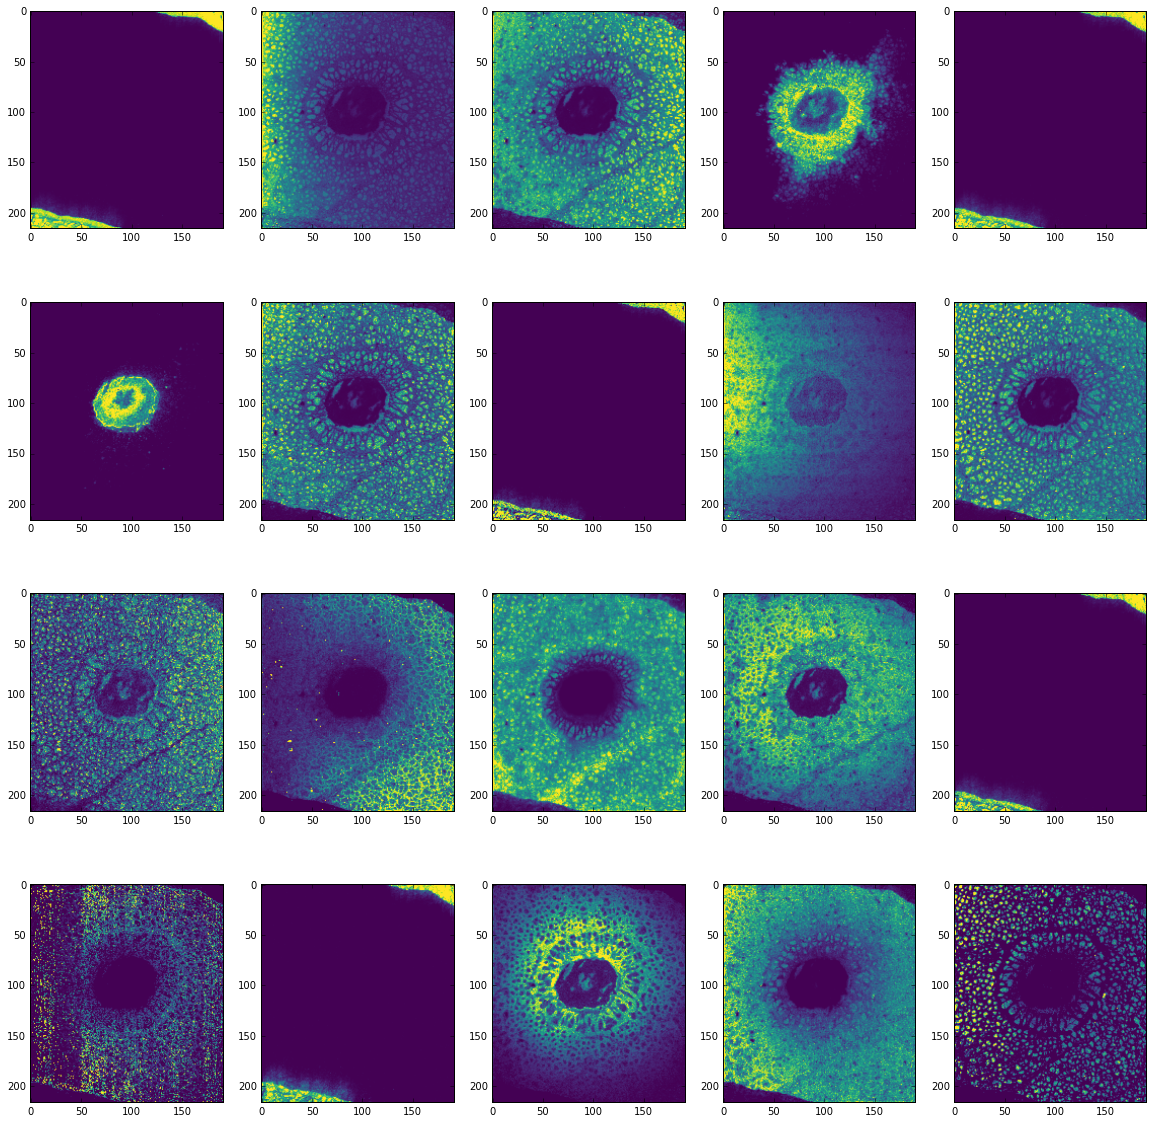

In [8]:
# take a look at the image components

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(arr_pos[cols[i],:], cmap='viridis')

In [9]:
%%time

# check factorization quality

da.vnorm(R, 'fro').compute() / da.vnorm(x, 'fro').compute()

CPU times: user 26.1 s, sys: 5.06 s, total: 31.2 s
Wall time: 8.42 s


0.011445496913607868

In [10]:
%%time

# get the coefficients for all m/z bins, not only for the brightest ones

H_full = nnls_frob(arr.reshape((arr.shape[0], -1)).T, 
                   arr_pos.reshape((arr_pos.shape[0], -1))[cols, :].T)
print H_full.shape

(20, 54154)
CPU times: user 29.6 s, sys: 3.27 s, total: 32.9 s
Wall time: 26.5 s


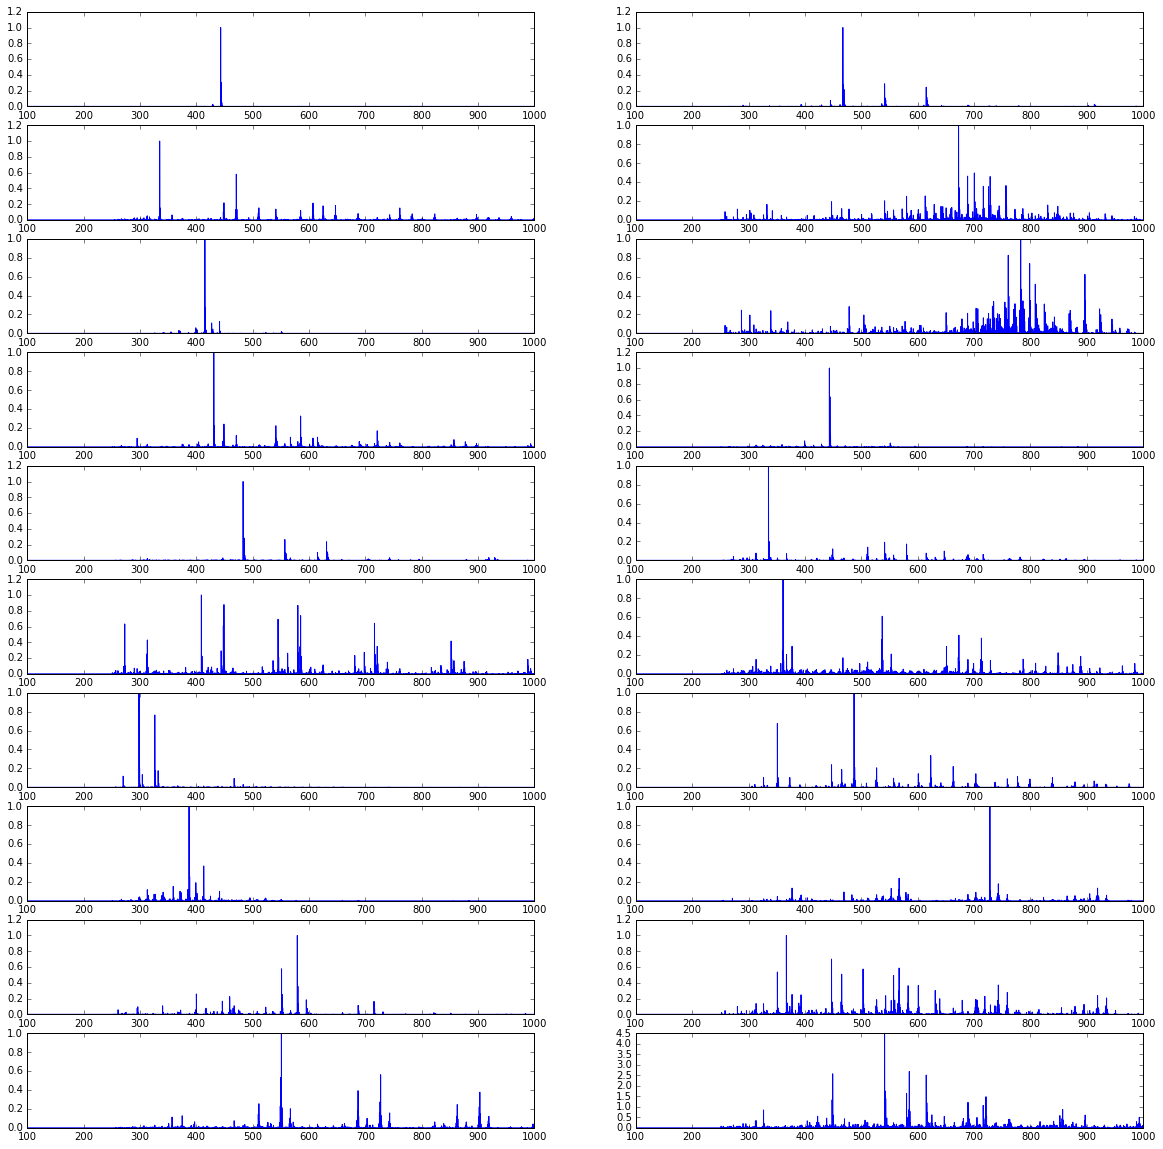

In [11]:
# look at the produced spectra

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(10, 2, i + 1)
    plt.plot([x[0] for x in mz_axis], H_full[i, :])

In [25]:
%%time

# finally, check the residuals for the factorization of the full matrix (>50000 m/z bins)

x = arr_pos.reshape((arr_pos.shape[0], -1)).T # bright m/z images
W = np.array(x[:, cols])
x_full = arr.reshape((arr.shape[0], -1)).T    # all m/z images
print W.shape, H_full.shape

norm_diff = 0.0
for chunk in partition_all(100, range(H_full.shape[1])):
    norm_diff += ((W.dot(H_full[:, chunk]) - x_full[:, chunk])**2).sum().compute()
norm_diff = np.sqrt(norm_diff)

print norm_diff / np.sqrt((arr ** 2).sum())

(41256, 20) (20, 54154)
0.0126920527528
CPU times: user 1min 58s, sys: 24.5 s, total: 2min 22s
Wall time: 1min 37s
